In [1]:
import os, import_ipynb
os.chdir('../..')
from Utils import *

importing Jupyter notebook from Utils.ipynb


In [2]:
img_files       = glob('data/1_time_series/gsr/*.csv')
eprime_path     = '/nfs/nfs-davinci/fahad/biobank/data/eprime_files'

fname           = img_files[0]
subj            = fname.split('/')[-1].split('_')[0].replace('.csv', '')
time_series     = pd.read_csv(fname, index_col=0)

eprime_fname    = "%s/%s_25748_2_0.txt" % (eprime_path, subj)
frames, ys      = load_frames(eprime_fname, time_series)

In [3]:
rois            = np.array(time_series.columns)

In [4]:
chunks, corrs, window_ys, window_times = window_timeseries(time_series, window=10, ys=ys)

In [5]:
stats, lags, pvals, corrs   = compute_tvfcn_gc(chunks, window=10)

100%|██████████| 33/33 [09:16<00:00, 16.86s/it]


In [6]:
stats.shape, lags.shape, pvals.shape, corrs.shape, rois.shape, len(window_ys)

((2116, 33), (2116, 33), (2116, 33), (2116, 33), (46,), 33)

In [7]:
results, rel_dict           = get_edge_types_gc(stats, lags, pvals, corrs, rois, window_ys)

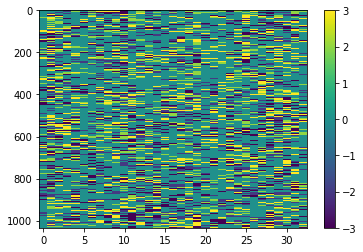

In [8]:
results = results.fillna('-')
plt.imshow(results.replace(rel_dict), aspect='auto');
plt.colorbar();

In [9]:
rel_dict_rev = {rel_dict[k]:k for k in rel_dict}

In [10]:
counts       = count_edge_types(results.replace(rel_dict), rel_dict_rev)

In [11]:
# window_ys = window_ys[:-1]

In [12]:
counts_face       = count_edge_types(results.loc[:,np.array(window_ys)=='Face'].replace(rel_dict), rel_dict_rev).replace({0:1})
counts_shape      = count_edge_types(results.loc[:,np.array(window_ys)=='Shape'].replace(rel_dict), rel_dict_rev).replace({0:1})

pvals             = counts_face.apply(lambda x: chi2_contingency([x.values, counts_shape.loc[x.name].values], lambda_=1)[1], axis=1)
pvals.name        = 'pvals'

In [15]:
labels            = counts[counts>20].fillna(0).apply(lambda x: pd.Series(edge_labels(x)), axis=1)
labels.columns    = ['nature', 'arrow']
merged            = pd.merge(labels, pvals, left_index=True, right_index=True)
sig_edges         = merged[merged['pvals']<(0.001/len(merged))].sort_values('pvals')

print(len(sig_edges)/len(merged))

0.25120772946859904


In [93]:
counts_face_filtered = counts_face.loc[sig_edges.index]
counts_shape_filtered = counts_shape.loc[sig_edges.index]

labels_face = counts_face_filtered[counts_face_filtered>20].fillna(0).apply(lambda x: pd.Series(edge_labels(x)), axis=1)
labels_shape = counts_shape_filtered[counts_shape_filtered>20].fillna(0).apply(lambda x: pd.Series(edge_labels(x)), axis=1)

labels_face.columns    = ['nature_face', 'arrow_face']
labels_shape.columns    = ['nature_shape', 'arrow_shape']

In [94]:
sig_edges_face  = pd.merge(labels_face, pvals, left_index=True, right_index=True)
sig_edges_shape = pd.merge(labels_shape, pvals, left_index=True, right_index=True)

In [95]:
sig_edges_merged = pd.merge(sig_edges_face, sig_edges_shape, left_index=True, right_index=True)
sig_edges_merged = sig_edges_merged[~((sig_edges_merged['nature_face'].isnull()) & (sig_edges_merged['nature_shape'].isnull()))]
# sig_edges_merged.columns = ['']

In [99]:
face_edges  = sig_edges_merged[sig_edges_merged['nature_shape'].isnull()].sort_values('pvals_x')
shape_edges = sig_edges_merged[sig_edges_merged['nature_face'].isnull()].sort_values('pvals_x')

In [128]:
pd.Series(results.values.flatten()).value_counts()

-         20459
x << y     3492
x >> y     3465
x < y      3447
x > y      3292
dtype: int64

In [184]:
from nltk.util import ngrams
import collections

content = results.loc[face_edges.index[0]].values
# content = [x for x in content if x!='-']
grams = ngrams(content, 2)
pd.Series(collections.Counter(grams)).sort_values(ascending=False)
# collections.Counter(grams)

-       -         7
x << y  -         4
-       x << y    3
        x < y     3
x << y  x << y    2
x >> y  x >> y    2
        -         2
x < y   x >> y    2
-       x > y     1
x > y   x > y     1
        -         1
-       x >> y    1
x >> y  x > y     1
x > y   x >> y    1
x < y   x << y    1
dtype: int64

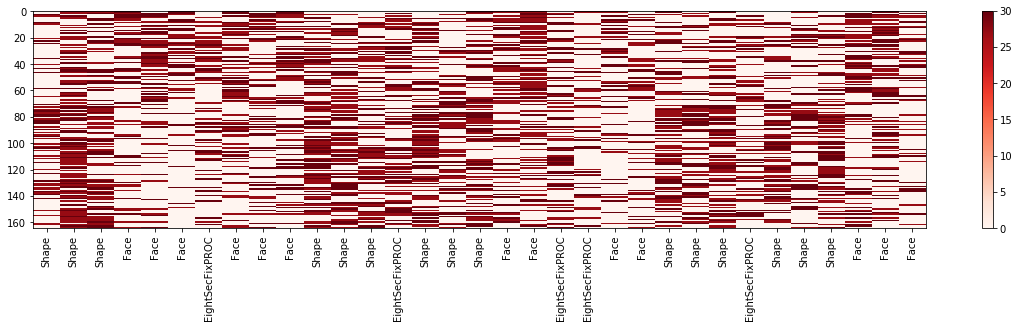

In [156]:
rel_dict2 = {'-': 0, 'x > y': 27, 'x >> y': -27, 'x < y': 30, 'x << y': -30}
plt.figure(figsize=(20, 4));
toplot = abs(results.loc[np.concatenate((face_edges.index, shape_edges.index))].replace(rel_dict2))
plt.imshow(toplot, aspect='auto', cmap='Reds');
plt.xticks(range(results.shape[1]), results.columns, rotation=90);
plt.colorbar();

In [28]:
G                 = construct_graph(sig_edges)

In [26]:
G_face            = construct_graph(sig_edges_face)
G_shape           = construct_graph(sig_edges_shape)

In [30]:
coords            = get_mni_coords('data/46_rois.nii.gz', rois)#list(time_series.columns))
pos               = coords[['y', 'z']].transpose().to_dict(orient='list')

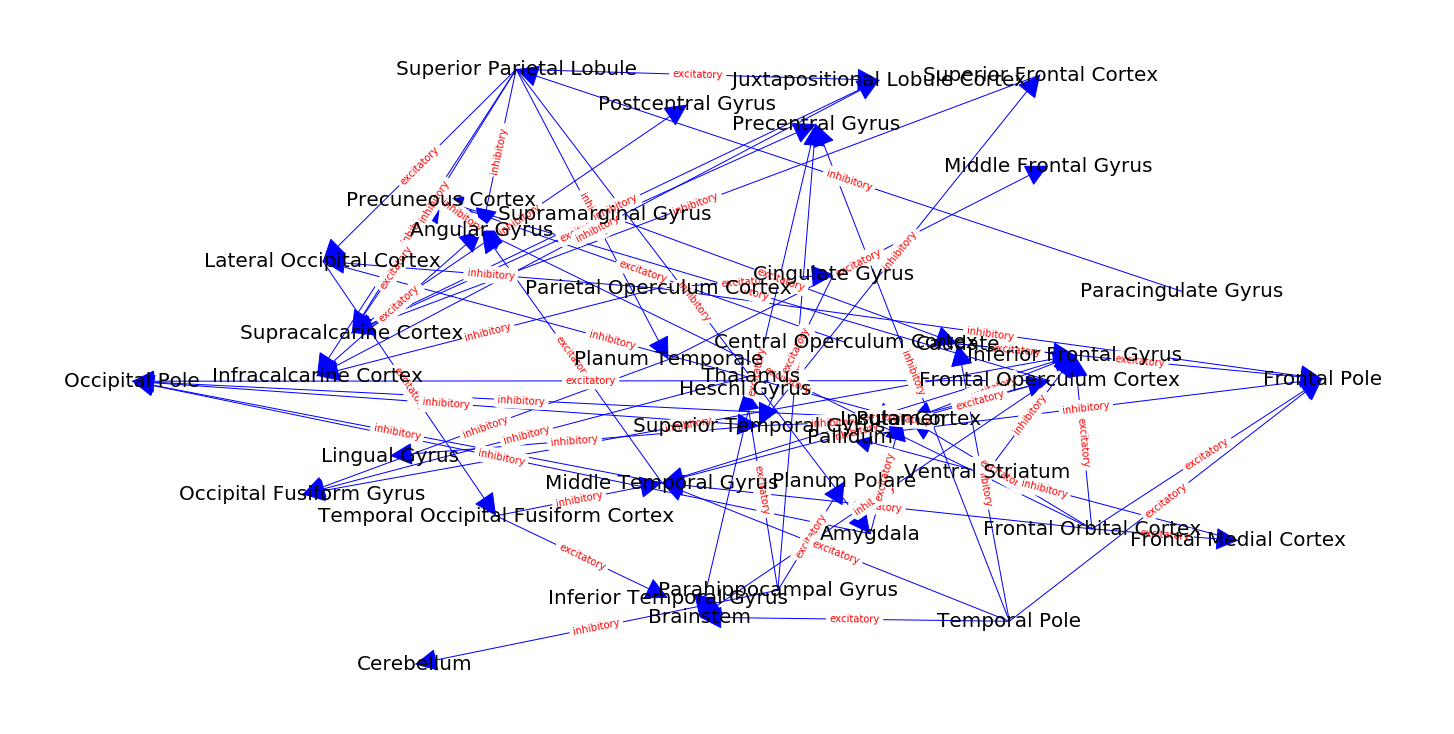

In [31]:
draw_graph(G, pos=pos);

In [32]:
cycles         = list(nx.simple_cycles(G))
cycles_face    = list(nx.simple_cycles(G_face))
cycles_shape   = list(nx.simple_cycles(G_shape))

In [42]:
nodes          = set([node for cycle in cycles for node in cycle])
face_nodes     = set([node for cycle in cycles_face for node in cycle])
shape_nodes    = set([node for cycle in cycles_shape for node in cycle])

In [54]:
subgraph       = G.subgraph(nodes)
subgraph_face  = G.subgraph(face_nodes)
subgraph_shape = G.subgraph(shape_nodes)

In [52]:
mni = datasets.load_mni152_brain_mask()

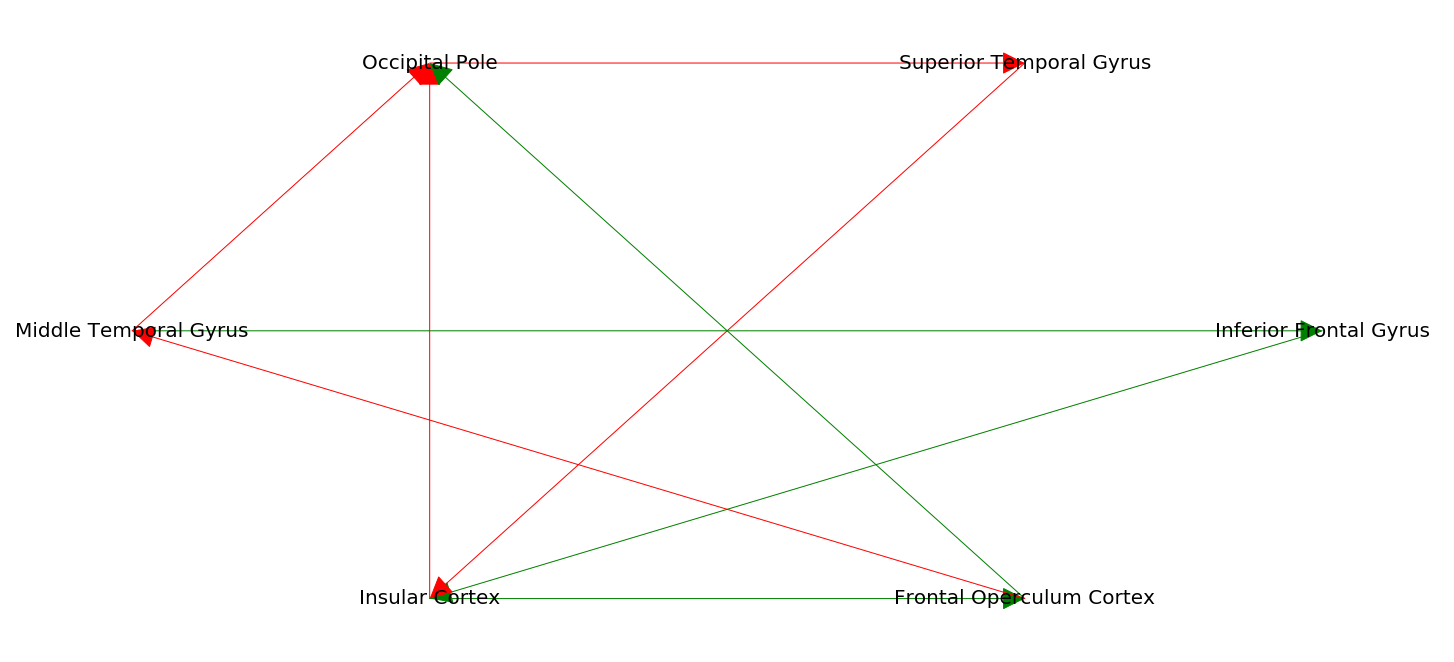

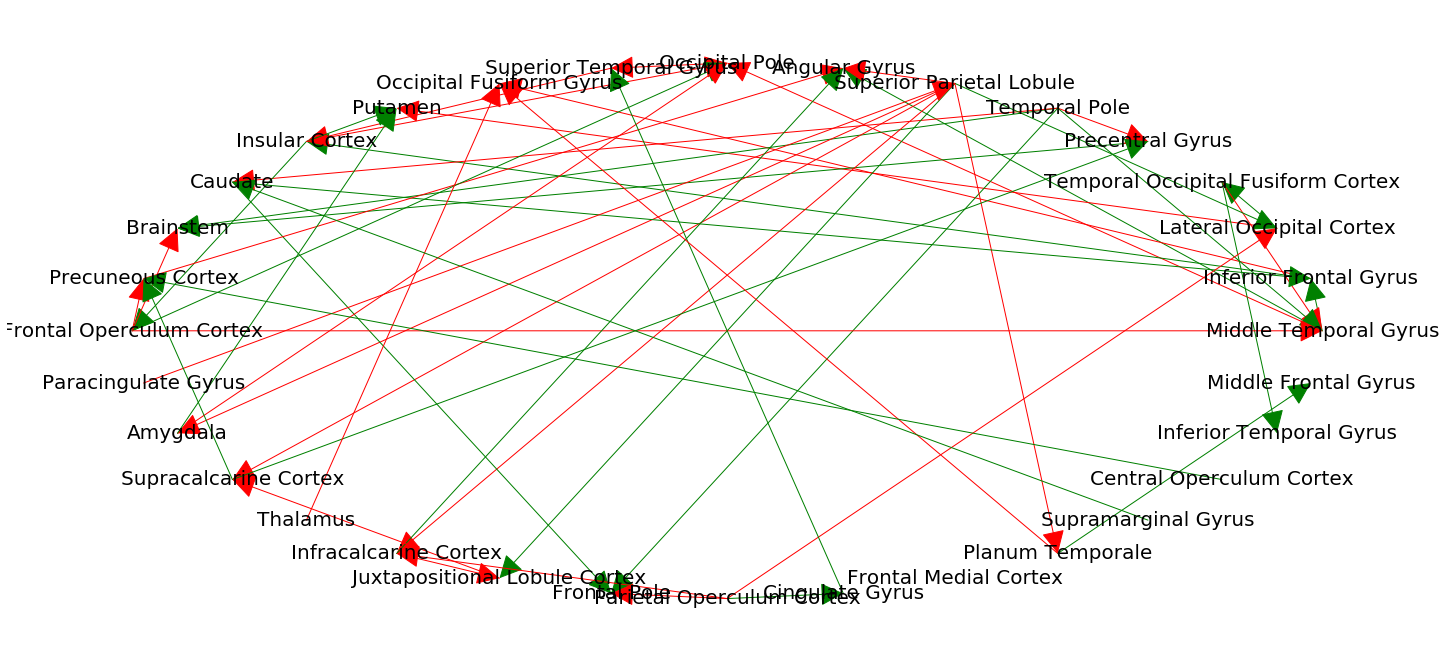

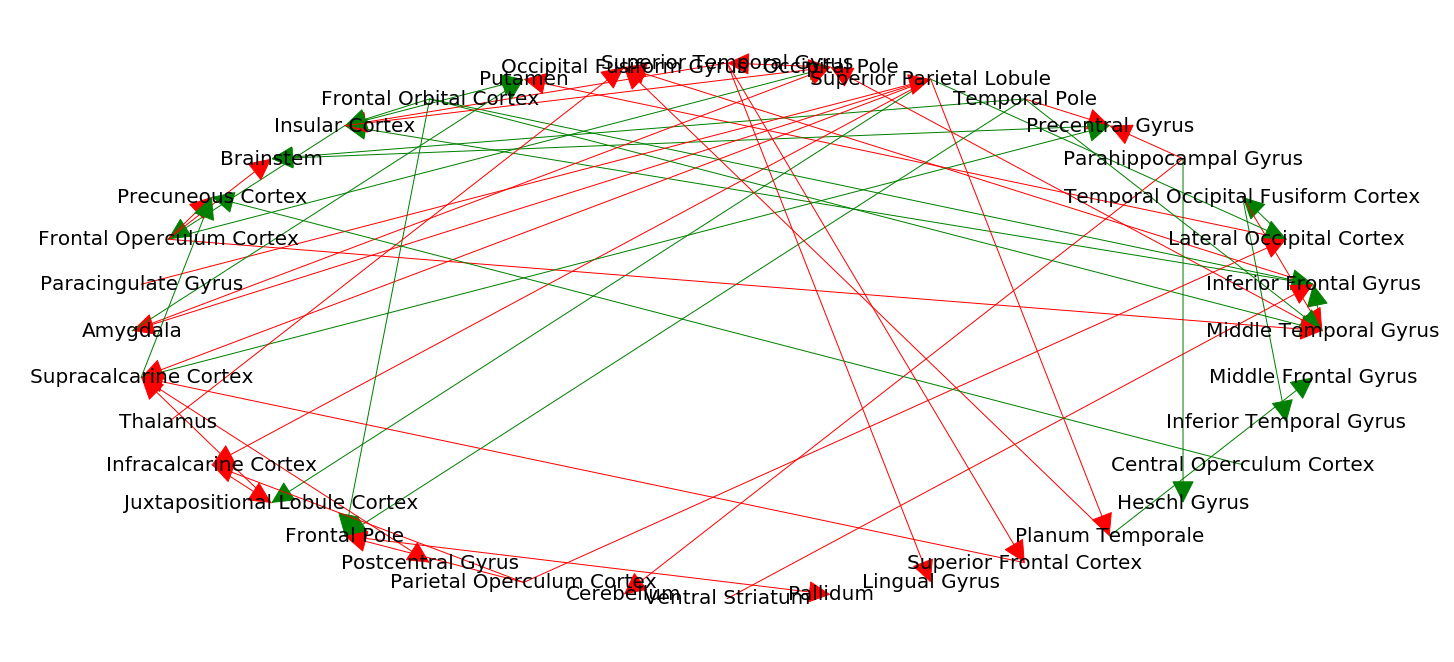

In [61]:
def draw_graph(G, layout=None, pos=None, edge_weights=False,\
               figsize=(20, 10), xlim=None, ylim=None, edgecolor='blue', fontcolor='red'):
    plt.figure(figsize=figsize)
#     bg_img = plt.imread("out/Brain_midsagital_view.png")
#     plt.imshow(bg_img, origin='upper',\
#                extent=[ -100, 25, -30, 50])#left, right, bottom, top
    if pos==None:
        pos = layout(G)

    weights = [G[u][v]['weight'] for u,v in G.edges()] if edge_weights else None
    
    edge_labels_formatted = {(e[0], e[1]):G.get_edge_data(e[0], e[1])['label'] for e in list(G.edges())}

    colors = ['green' if edge_labels_formatted[k]=='excitatory' else 'red'\
          for k in edge_labels_formatted]
    
    nx.draw(G, with_labels=True, pos=pos, edge_color=colors, arrowsize=50, font_size=20, node_size=0, width=weights)
#     nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels_formatted,\
#                                  font_color=fontcolor, font_size=20);
#     plt.grid()

pos2 = nx.circular_layout(subgraph)
draw_graph(subgraph, pos=pos2, fontcolor='black', figsize=(20, 9));

pos2 = nx.circular_layout(subgraph_face)
draw_graph(subgraph_face, pos=pos2, fontcolor='black', figsize=(20, 9));

pos2 = nx.circular_layout(subgraph_shape)
draw_graph(subgraph_shape, pos=pos2, fontcolor='black', figsize=(20, 9));

In [199]:
import schemdraw
from schemdraw import dsp
from schemdraw import flow

In [303]:
rois2functional = pd.read_csv('out/rois46functional.csv', index_col=0)

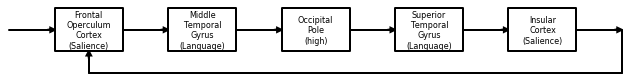

In [457]:
d = schemdraw.Drawing(unit=2, fontsize=8, inches_per_unit=0.35)
nodes = {}
d.add(flow.Arrow(d='right'))
for x in cycle:
    label = x.replace(' ', '\n')
    label = label+'\n(%s)' % rois2functional.loc[x, '0']
    nodes[x] = d.add(flow.Box(label=label, anchor='W'))
    d.add(flow.Arrow(d='right', at=nodes[x].E))
d.add(flow.Line(d='down'))
d.add(flow.Line(d='left', tox=nodes[cycle[0]].S))
d.add(flow.Arrow(d='up', toy=nodes[cycle[0]].S))

d.draw()

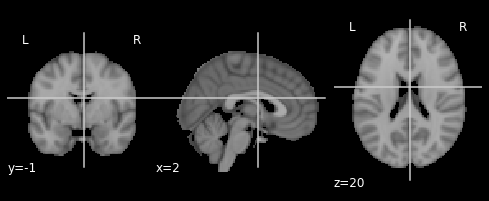

In [526]:
plotting.plot_anat()

/home/fahad/anaconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:1609: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])


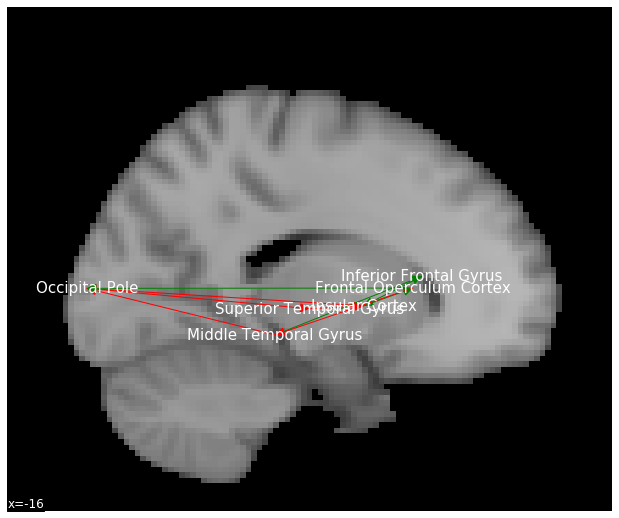

In [48]:
def draw_graph(G, layout=None, pos=None, edge_weights=False,\
               figsize=(20, 10), xlim=None, ylim=None, edgecolor='blue',\
               fontcolor='red', fontsize=20, arrowsize=50):
    
    fig = plt.figure(figsize=figsize)
    ax = plotting.plot_anat(datasets.load_mni152_template(), display_mode='x', cut_coords=1, figure=fig).axes[-16].ax
    if pos==None:
        pos = layout(G)

    weights = [G[u][v]['weight'] for u,v in G.edges()] if edge_weights else None
    
    edge_labels_formatted = {(e[0], e[1]):G.get_edge_data(e[0], e[1])['label'] for e in list(G.edges())}

    colors = ['green' if edge_labels_formatted[k]=='excitatory' else 'red'\
          for k in edge_labels_formatted]
    
    nx.draw(G, with_labels=True, pos=pos, edge_color=colors, \
            arrowsize=arrowsize, font_size=fontsize, node_size=0, width=weights, ax=ax, font_color='white')
#     nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels_formatted,\
#                                  font_color=fontcolor, font_size=fontsize);
    
draw_graph(subgraph, pos=pos, fontcolor='black', figsize=(10, 7), fontsize=15, arrowsize=20);